In [1]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import sys
import dataset

# sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

# print(torch.cuda.get_device_name(0))
# sns.set()

Device: cuda


### Visualization functions

In [11]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

'''
NOTE: when using lab color space we have certain artefacts that do not appear when we only use RGB images

may be from normalization in the lab space or the transformation itself

TODO
'''
def visualize(entry,model,lab=False):
    image = entry['grayscale_image']
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu().squeeze(0)
    print(output.shape)

    if lab:
        lab2rgb = dataset.LABtoRGB()
        rgb_image = lab2rgb(entry['image'])
        output = lab2rgb(torch.cat((entry['image'][0,:,:].unsqueeze(0),output),0))
        print("Shape of combined lab image:",output.shape)
    # output = compose_output(image,output[0])

    plot_both(rgb_image.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


In [3]:

def plot_grid(images_column1, images_column2):
    '''
    Plots a 2x8 grid of rgb images, where each row corresponds to a pair of images from the two input lists.
    '''
    num_images_column1 = len(images_column1)
    num_images_column2 = len(images_column2)
    num_rows = max(num_images_column1, num_images_column2)
    
    plt.figure(figsize=(12, 8))  # Adjust figsize as needed

    for i in range(num_rows):
        # Plot images from the first column
        if i < num_images_column1:
            plt.subplot(num_rows, 2, 2*i + 1)
            plt.imshow(images_column1[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 1)')
            plt.axis('off')  # Turn off axis for better visualization
        
        # Plot images from the second column
        if i < num_images_column2:
            plt.subplot(num_rows, 2, 2*i + 2)
            plt.imshow(images_column2[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 2)')
            plt.axis('off')  # Turn off axis for better visualization

    plt.tight_layout(pad=0.1)  # Adjust spacing between subplots
    plt.show()

def get_visualization_images(indexes):
    data = list(train_data)
    tbr = []
    for idx in indexes:
        tbr.append(data[idx]['image'])

    return tbr

def get_batch_outputs(images):
    ## batch the images
    images = torch.stack(images)
    output = net(images.to(device))
    return [output[i].detach().cpu() for i in range(output.shape[0])]

### Architecture

In [4]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)


    def forward(self,x):
        x=x.to(device)
        # Encoder
        conv1 = self.conv1(x)
        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)

        # Decoder
        concatenation_5to6 = torch.cat((conv4, self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, 
                    epochs=10, 
                    lr=0.001, 
                    loss_fn=nn.MSELoss(), 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''


        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['grayscale_image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                ## aici trebuie comparat doar cu canalele ab
                if colorspace == 'RGB':
                    loss = loss_fn(reproduced_image, batch_data['image'].to(device))
                elif colorspace == 'LAB':
                    loss = loss_fn(reproduced_image, batch_data['image'][:,1:,:,:].to(device))
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['grayscale_image']
                        val_image = val_image.to(device)

                        val_reproduced_image = self(val_image)
                        val_reproduced_image = val_reproduced_image.to(device)
                        if colorspace == 'RGB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'].to(device)).item()
                        elif colorspace == 'LAB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'][:,1:,:,:].to(device)).item()
                       
                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


### Colorization from RGB color space. 

Input is a HxW grayscale image.
Output is a 3xHxW RGB image.

No std and mean normalization is used.

In [ ]:
TRAIN_SIZE = 100
VAL_SIZE = 100
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='RGB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

In [ ]:
model = UNet(in_C=1, out_C=3)


In [ ]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=150, lr=0.0001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path= 'experiment_results/LAB_100', save_name_prefix='/1000_training_')

In [ ]:
visualize(list(train_data)[32],model,lab=False)

### Colorization from LAB color space. 

Input is a HxW grayscale image (the l channel).
Output is 2xHxW representing the ab channels.

No std and mean normalization is used.

In [5]:
TRAIN_SIZE = 100
VAL_SIZE = 100
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='LAB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

Dataset loaded successfully
Data loader prepared successfully


'\nSince the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same\n'

In [6]:
model = UNet(in_C=1, out_C=2)

In [7]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                  epochs=150, 
                  lr=0.0001, 
                  loss_fn=nn.MSELoss(), 
                  optimizer=torch.optim.Adam, 
                  verbose=True, 
                  save_path= 'experiment_results/LAB_100', 
                  save_name_prefix='/1000_training_',
                  colorspace='LAB')

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, training_loss = 0.4210618393761771
Epoch 0: validation loss = 0.34509728636060444


  3%|▎         | 5/150 [00:09<04:23,  1.82s/it]

Epoch 5, training_loss = 0.2451114399092538
Epoch 5: validation loss = 0.2418622225522995


  7%|▋         | 10/150 [00:19<04:11,  1.80s/it]

Epoch 10, training_loss = 0.22370004866804397
Epoch 10: validation loss = 0.22344596896852767


 10%|█         | 15/150 [00:28<04:01,  1.79s/it]

Epoch 15, training_loss = 0.20923016965389252
Epoch 15: validation loss = 0.20920030772686005


 13%|█▎        | 20/150 [00:38<03:51,  1.78s/it]

Epoch 20, training_loss = 0.1968951459441866
Epoch 20: validation loss = 0.19547566132886068


 17%|█▋        | 25/150 [00:47<03:43,  1.79s/it]

Epoch 25, training_loss = 0.18215108982154302
Epoch 25: validation loss = 0.18194255658558436


 20%|██        | 30/150 [00:57<03:35,  1.79s/it]

Epoch 30, training_loss = 0.16996252962521144
Epoch 30: validation loss = 0.16814771081720079


 23%|██▎       | 35/150 [01:07<03:25,  1.79s/it]

Epoch 35, training_loss = 0.15546163065092905
Epoch 35: validation loss = 0.153694463627679


 27%|██▋       | 40/150 [01:16<03:16,  1.79s/it]

Epoch 40, training_loss = 0.13810650152819498
Epoch 40: validation loss = 0.1389293372631073


 30%|███       | 45/150 [01:26<03:08,  1.80s/it]

Epoch 45, training_loss = 0.12343811563083104
Epoch 45: validation loss = 0.12402786953108651


 33%|███▎      | 50/150 [01:35<02:59,  1.79s/it]

Epoch 50, training_loss = 0.10761419577257973
Epoch 50: validation loss = 0.10889227156128202


 37%|███▋      | 55/150 [01:45<02:50,  1.80s/it]

Epoch 55, training_loss = 0.09343144191162926
Epoch 55: validation loss = 0.09409507364034653


 40%|████      | 60/150 [01:54<02:41,  1.80s/it]

Epoch 60, training_loss = 0.07866828995091575
Epoch 60: validation loss = 0.07992437056132726


 43%|████▎     | 65/150 [02:04<02:32,  1.80s/it]

Epoch 65, training_loss = 0.06808132412178176
Epoch 65: validation loss = 0.06665683537721634


 47%|████▋     | 70/150 [02:13<02:24,  1.80s/it]

Epoch 70, training_loss = 0.05283453155841146
Epoch 70: validation loss = 0.054444994777441025


 50%|█████     | 75/150 [02:23<02:15,  1.80s/it]

Epoch 75, training_loss = 0.04142898480807032
Epoch 75: validation loss = 0.04384538744177137


 53%|█████▎    | 80/150 [02:33<02:05,  1.80s/it]

Epoch 80, training_loss = 0.033500674845916886
Epoch 80: validation loss = 0.03479699684040887


 57%|█████▋    | 85/150 [02:42<01:57,  1.80s/it]

Epoch 85, training_loss = 0.025536942162684033
Epoch 85: validation loss = 0.027428477736456052


 60%|██████    | 90/150 [02:52<01:47,  1.80s/it]

Epoch 90, training_loss = 0.019204056954809597
Epoch 90: validation loss = 0.020972653159073422


 63%|██████▎   | 95/150 [03:01<01:39,  1.80s/it]

Epoch 95, training_loss = 0.014046863253627504
Epoch 95: validation loss = 0.01623877656779119


 67%|██████▋   | 100/150 [03:11<01:30,  1.81s/it]

Epoch 100, training_loss = 0.009939440792160375
Epoch 100: validation loss = 0.012507146357425622


 70%|███████   | 105/150 [03:21<01:21,  1.81s/it]

Epoch 105, training_loss = 0.006890267599374056
Epoch 105: validation loss = 0.009682977705129556


 73%|███████▎  | 110/150 [03:30<01:12,  1.81s/it]

Epoch 110, training_loss = 0.005099118088505098
Epoch 110: validation loss = 0.007940581933196102


 77%|███████▋  | 115/150 [03:40<01:03,  1.81s/it]

Epoch 115, training_loss = 0.003826055210083723
Epoch 115: validation loss = 0.006646151055714914


 80%|████████  | 120/150 [03:49<00:54,  1.81s/it]

Epoch 120, training_loss = 0.0032081514530416045
Epoch 120: validation loss = 0.0056537071775112835


 83%|████████▎ | 125/150 [03:59<00:45,  1.81s/it]

Epoch 125, training_loss = 0.0026253169469003168
Epoch 125: validation loss = 0.0052830844984522885


 87%|████████▋ | 130/150 [04:09<00:36,  1.81s/it]

Epoch 130, training_loss = 0.00207425033607121
Epoch 130: validation loss = 0.004988292963909251


 90%|█████████ | 135/150 [04:18<00:27,  1.81s/it]

Epoch 135, training_loss = 0.0017098330925883992
Epoch 135: validation loss = 0.004866308665701321


 93%|█████████▎| 140/150 [04:28<00:18,  1.81s/it]

Epoch 140, training_loss = 0.0013681126625410148
Epoch 140: validation loss = 0.004134527607155698


 97%|█████████▋| 146/150 [04:40<00:08,  2.02s/it]

Epoch 145, training_loss = 0.0011990785133093596
Epoch 145: validation loss = 0.004354835587686726


100%|██████████| 150/150 [04:48<00:00,  1.92s/it]

Epoch 149, training_loss = 0.0010745686179559147
Epoch 149: validation loss = 0.004216252094400781


<Figure size 640x480 with 0 Axes>

torch.Size([2, 128, 128])
Shape of combined lab image: torch.Size([3, 128, 128])


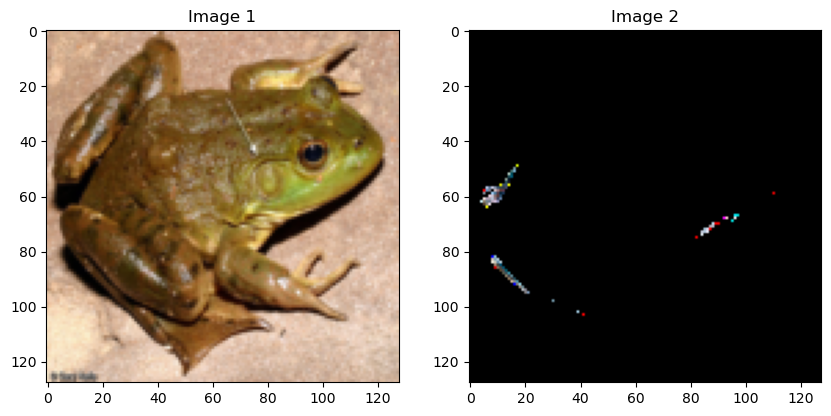

In [12]:

visualize(list(train_data)[32],model,lab=True)

In [ ]:

visualize(list(train_data)[78],model,lab=True)

In [ ]:

visualize(list(train_data)[5],model,lab=True)

In [ ]:
## must have length 8!
images_to_visualize_indexes = [3,12,5,17,11,3,28,29]

visualization_images = get_visualization_images(images_to_visualize_indexes)
outputs = get_batch_outputs(visualization_images)
plot_grid(visualization_images, outputs)